In [94]:
# -*- coding: utf-8 -*-
import numpy as np
import platform
import tempfile
import os
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
# necessite scikit-image 
from skimage import io as skio
from datetime import datetime


# POUR LA MORPHO
from skimage.segmentation import watershed 
from skimage.feature import peak_local_max



In [81]:
#%%
# VOUS DEVEZ FIXER LES DEUX VARIABLES SUIVANTES: 
colaboratory=False #mettre True si vous utilisez google colab
notebook=True   # mettre Trus si vous utilisez un notebook local
# les seuls couples possibles sont (False,False)= travailler localement sans notebook
# (False,True): jupyternotebook local
# (True, False): google colab


assert (not (colaboratory and notebook)), "Erreur, choisissez google colab ou notebook local mais pas les deux en meme temps"

if colaboratory: #Si google colab on installe certaines librairies
    !pip install soundfile
    from IPython.display import Audio
    !pip install bokeh
    from bokeh.plotting import figure, output_file, show
    from bokeh.plotting import show as showbokeh
    from bokeh.io import output_notebook
    output_notebook()
    !wget https://perso.telecom-paristech.fr/ladjal/donnees_IMA203.tgz
    !tar xvzf donnees_IMA203.tgz
    os.chdir('donnees_IMA203')

if notebook: # si notebook normal dans une machine locale vous devez installer bokeh vous-meme
    from bokeh.plotting import figure, output_file, show
    from bokeh.plotting import show as showbokeh
    from bokeh.io import output_notebook
    output_notebook()
    





Loading BokehJS ...

In [82]:
#%% fonction pour voir une image




def viewimage(im,normalise=True,MINI=0.0, MAXI=255.0,titre=''):
    """ Cette fonction fait afficher l'image EN NIVEAUX DE GRIS 
        dans gimp. Si un gimp est deja ouvert il est utilise.
        Par defaut normalise=True. Et dans ce cas l'image est normalisee 
        entre 0 et 255 avant d'être sauvegardee.
        Si normalise=False MINI et MAXI seront mis a 0 et 255 dans l'image resultat
        
    """
    imt=np.float32(im.copy())
    if platform.system()=='Darwin': #on est sous mac
        prephrase='open -a /Applications/GIMP.app '
        endphrase=' &' 
    elif platform.system()=='Linux': #SINON ON SUPPOSE LINUX (si vous avez un windows je ne sais comment faire. Si vous savez dites-moi.)
        prephrase='gimp -a '
        endphrase= ' &'
    elif platform.system()=='Windows':
        prephrase='start /B "D:/GIMP/bin/gimp-2.10.exe" -a '#Remplacer D:/... par le chemin de votre GIMP
        endphrase= ''
    else:
        print('Systeme non pris en charge par l affichage GIMP')
        return 'erreur d afficahge'
    
    if normalise:
        m=imt.min()
        imt=imt-m
        M=imt.max()
        if M>0:
            imt=imt/M

    else:
        imt=(imt-MINI)/(MAXI-MINI)
        imt[imt<0]=0
        imt[imt>1]=1
    
    if titre!='':
        titre='_'+titre+'_'
    nomfichier=tempfile.mktemp('TPIMA'+titre+'.png')
    commande=prephrase +nomfichier+endphrase
    skio.imsave(nomfichier,imt)
    os.system(commande)

#si on est dans un notebook (y compris dans colab), on utilise bokeh pour visualiser

usebokeh= colaboratory or notebook
if usebokeh:
    def normalise_image_pour_bokeh(X,normalise,MINI,MAXI):
        imt=np.copy(X.copy())
        if normalise:
            m=imt.min()
            imt=imt-m
            M=imt.max()
            if M>0:
                imt=imt/M

        else:
            
            imt=(imt-MINI)/(MAXI-MINI)
            imt[imt<0]=0
            imt[imt>1]=1
        imt*=255
      
        sortie=np.empty((*imt.shape,4),dtype=np.uint8)
        for k in range(3):
            sortie[:,:,k]=imt
        sortie[:,:,3]=255
        return sortie
    def viewimage(im,normalise=True,MINI=0.0, MAXI=255.0,titre=''):
        
        img=normalise_image_pour_bokeh(np.flipud(im),normalise,MINI,MAXI)# np.flipud(np.fliplr(im)))
        p = figure(tooltips=[("x", "$x"), ("y", "$y"), ("value", "@image")],title=titre)
        p.x_range.range_padding = p.y_range.range_padding = 0

        # must give a vector of images
        p.image_rgba(image=[img], x=0,y=0, dw=im.shape[1], dh=im.shape[0])
        showbokeh(p)

  


In [83]:
#%% fonctions utiles au TP

def appfiltre(u,K):
    """ applique un filtre lineaire (en utilisant une multiplication en Fourier) """

    fft2=np.fft.fft2
    ifft2=np.fft.ifft2
    out=np.real(ifft2(fft2(u)*fft2(K)))
    return out    

def degrade_image(im,br): 
    """degrade une image en lui ajoutant du bruit"""
    out=im+br*np.random.randn(*im.shape)
    return out

def  grady(I):
    """ Calcule le gradient en y de l'image I, avec condition de vonnewman au bord
     i.e. l'image est symétrisée et le gradient en bas est nul"""
    
    (m,n)=I.shape
    M=np.zeros((m,n))
    M[:-1,:]=-I[:-1,:]+I[1:,:]
    M[-1,:]=np.zeros((n,))
    return M

def  gradx(I):
    """ Calcule le gradient en y de l'image I, avec condition de vonnewman au bord
     i.e. l'image est symétrisée et le gradient a droite est nul"""
    
    (m,n)=I.shape
    M=np.zeros((m,n))
    M[:,:-1]=-I[:,:-1]+I[:,1:]
    M[:,-1]=np.zeros((m,))
    return M

def div(px,py): 
    """calcule la divergence d'un champ de gradient"""
    """ div= - (grad)^*, i.e. div est la transposee de l'operateur gradient"""
    (m,n)=px.shape 
    assert px.shape==py.shape , " px et py n'ont pas la meme taille dans div"
    Mx=np.zeros((m,n))
    My=np.zeros((m,n))
    
    My[1:-1,:]=py[1:-1,:]-py[:-2,:]
    My[0,:]=py[0,:]
    My[-1,:]=-py[-2,:]
    
    Mx[:,1:-1]=px[:,1:-1]-px[:,:-2]
    Mx[:,0]=px[:,0]
    Mx[:,-1]=-px[:,-2]
    return Mx+My

def gradient_TV(v,u,lamb):
    """ calcule le gradient de la fonctionnelle E2 du TP"""
# on n'utilise pas gradx et grady car pour minimiser 
# la fonctionnelle E2 par descente de gradient nous avons choisi 
# de prendre les memes conditions au bords que pour la resolution quadratique
    (sy,sx)=v.shape
    Kx=np.zeros((sy,sx))
    Ky=np.zeros((sy,sx))
    Kx[0,0]=1
    Kx[0,1]=-1
    Ky[0,0]=1
    Ky[1,0]=-1
    Kxback=np.zeros((sy,sx))
    Kyback=np.zeros((sy,sx))
    Kxback[0,0]=-1
    Kxback[0,-1]=1
    Kyback[0,0]=-1
    Kyback[-1,0]=1

    Dx=appfiltre(u,Kx)
    Dy=appfiltre(u,Ky)
    ng=(Dx**2+Dy**2)**0.5+1e-5
    div=appfiltre(Dx/ng,Kxback)+appfiltre(Dy/ng,Kyback)
    return 2*(u-v)-lamb*div

def gradient_TV_nonperiodique(v,u,lamb):
     """ calcule le gradient de la fonctionnelle E2 du TP"""
     gx=gradx(u)
     gy=grady(u)
     ng=((gx**2)+(gy**2))**0.5+1e-5
     dive=div(gx/ng,gy/ng)
     return 2*(u-v)-lamb*dive
     

def resoud_quad_fourier(K,V):
    """trouve une image im qui minimise sum_i || K_i conv im - V_i||^2
     ou les K_i et les Vi sont des filtres et des images respectivement """
     
    n=len(K)
    assert len(K) == len(V) , "probleme de nombre de composantes dans resoud_quad"
    (sy,sx)=K[0].shape
    numer=np.vectorize(np.complex)(np.zeros((sy,sx)))
    denom=np.vectorize(np.complex)(np.zeros((sy,sx)))
    fft2=np.fft.fft2
    ifft2=np.fft.ifft2
    for k in range(n):
        fV=fft2(V[k])
        fK=fft2(K[k])
        #print('type de fV',fV.dtype,' type de fK',fK.dtype)
        numer+=np.conj(fK)*fV
        denom+=abs(fK)**2
    return np.real(ifft2(numer/denom))

def minimisation_quadratique(v,lamb):
    """ minimise la fonctionnelle E1 du TP"""
    (sy,sx)=v.shape
    # print(v.shape)
    Kx=np.zeros((sy,sx)) # noyaux de la meme taille que l'image originale
    Ky=np.zeros((sy,sx))
    Kx[0,0]=1
    Kx[0,1]=-1
    Ky[0,0]=1
    Ky[1,0]=-1
    delta=np.zeros((sy,sx))
    delta[0,0]=1.0
    s=lamb**0.5
    K=(s*Kx,s*Ky,delta)
    V=(np.zeros((sy,sx)),np.zeros((sy,sx)),v)
    return resoud_quad_fourier(K,V)

def norme_VT(I): 
    """ renvoie la norme de variation totale de I"""
    (sy,sx)=I.shape
    Kx=np.zeros((sy,sx))
    Ky=np.zeros((sy,sx))
    Kx[0,0]=1
    Kx[0,1]=-1
    Ky[0,0]=1
    Ky[1,0]=-1
    Dx=appfiltre(I,Kx)
    Dy=appfiltre(I,Ky)
    ng=(Dx**2+Dy**2)**0.5
    return ng.sum()

def norme_VT_nonperiodique(u):
    gx=gradx(u)
    gy=grady(u)
    ng=((gx**2)+(gy**2))**0.5
    return ng.sum()

def norm2(x):
    return ((x**2).sum())**0.5

def E2_nonperiodique(u,v,lamb): # renvoie l'énergie E2
    return lamb*norme_VT_nonperiodique(u)+norm2(u-v)**2


def minimise_TV_gradient(v,lamb,pas,nbpas):
    """ minimise E2 par descente de gradient a pas constant """
    u=np.zeros(v.shape)
    Energ=np.zeros(nbpas)
    for k in range(nbpas):
        # print(k)
        Energ[k]=E2_nonperiodique(u,v,lamb)
        u=u-pas*gradient_TV_nonperiodique(v,u,lamb)
    return (u,Energ)


def projection(I,a,itmax): 
    """ calcule la projection de I sur G_a
        G_a est le sous-gradient de TV en zero
        Comme vu dans le poly cette projection permet de resoudre le probleme
        de debruitage TV (E2)"""
    # ici on utilise les conditions au bord de von neuman 
    # i.e. on utilise gradx et grady definis plus haut et non pas une convolution circulaire
    (m,n)=I.shape
    t=0.1249
    px=np.zeros((m,n))
    py=np.zeros((m,n))
    un=np.ones((m,n))
    
    for it in range(itmax):
        N=div(px,py)-I/a
        Gx=gradx(N)
        Gy=grady(N)
        G=(Gx**2+Gy**2)**0.5
        pxnew=(px+t*Gx)/(un+t*G)
        pynew=(py+t*Gy)/(un+t*G)
        px=pxnew
        py=pynew
    # la projection est la divergence du champ px,py
    P=a*div(px,py)
    return P                

def vartotale_Chambolle(v,lamb,itmax=100):
    """ Trouve une image qui minimise lamb*TV(I)+||I-v||^2 
    en utilisant la projection dur G_a"""
    (m,n)=v.shape
    P=projection(v,lamb/2,itmax)
    return v-P


def imread(fichier):
    return np.float32(skio.imread(fichier))


In [84]:
#%% lire une image

im=imread('lena.tif') #ATTENTION IL FAUT ETRE DANS LE BON REPERTOIRE (utiliser os.chdir())



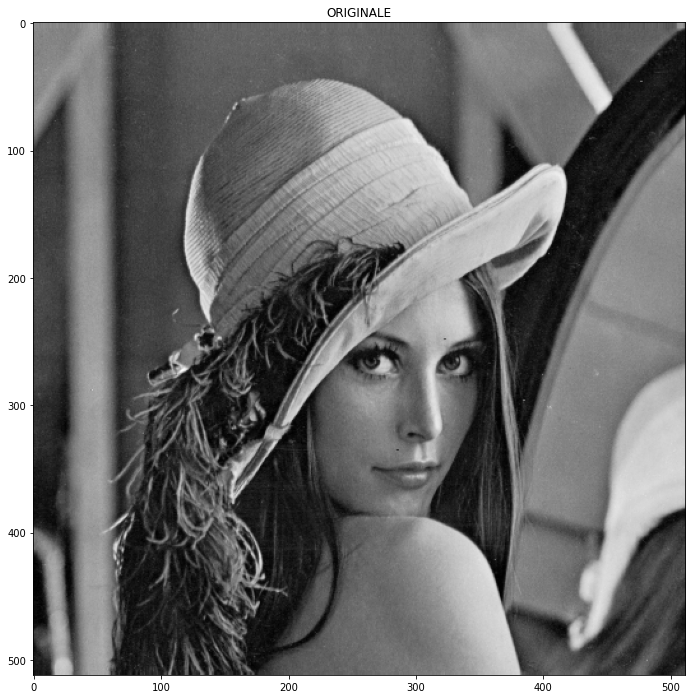

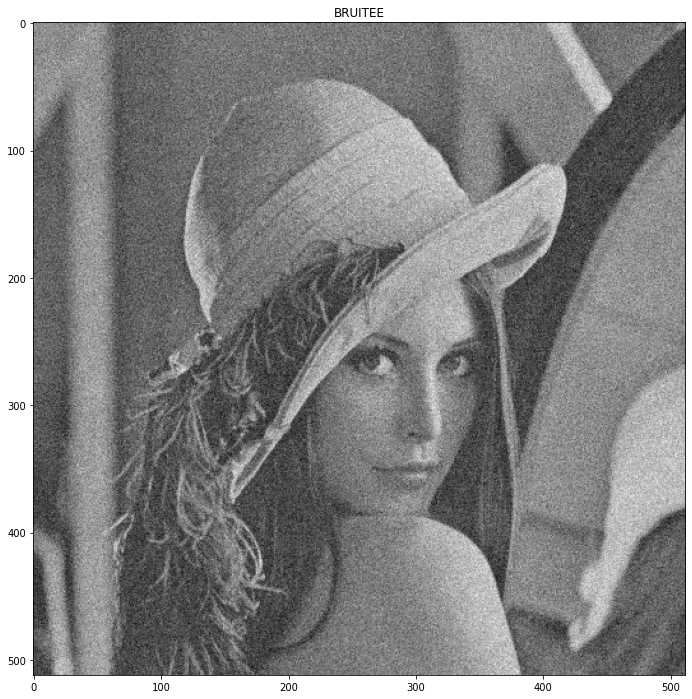

In [85]:
#%%

# voir l'image
plt.figure(figsize=(12, 12))
plt.imshow(im, cmap='gray')
plt.title('ORIGINALE')
#degrader une image

imb=degrade_image(im,25)

# voir l'image bruitée 
plt.figure(figsize=(12, 12))
plt.title('BRUITEE')
plt.imshow(imb, cmap='gray')

plt.show()




C:\Users\Louis\AppData\Local\Temp\ipykernel_35152\195593236.py:94: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  numer=np.vectorize(np.complex)(np.zeros((sy,sx)))
C:\Users\Louis\AppData\Local\Temp\ipykernel_35152\195593236.py:95: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  denom=np.vectorize(np.complex)(np.zeros((sy,sx

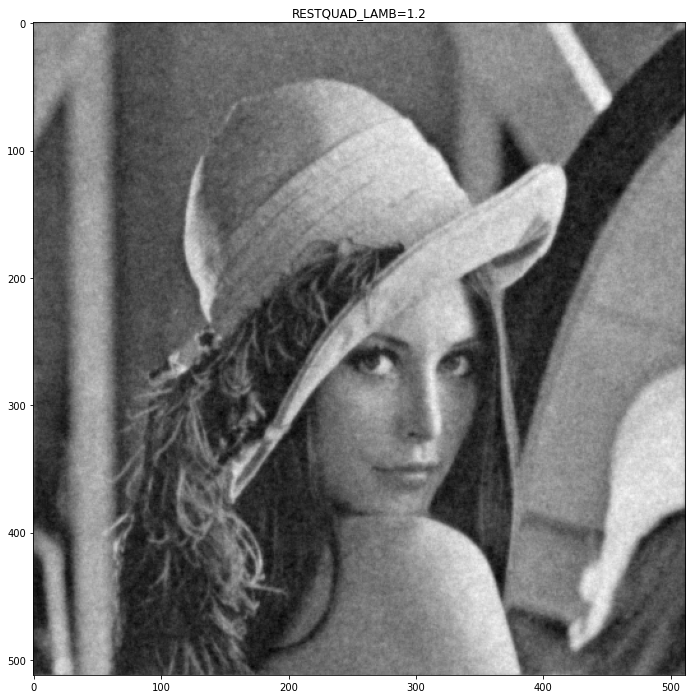

In [86]:
#%% restauration quadratique : exemple
lamb=1.2
restau=minimisation_quadratique(imb,lamb)
plt.figure(figsize=(12,12))
plt.title(f'RESTQUAD_LAMB={lamb}')
plt.imshow(restau, cmap='gray')
plt.show()



In [87]:
dist=norm2(im-imb)

def dichotomie(array, element):
    start=0
    stop=len(array)-1
    found=False

    while start <= stop and not found:
        mid = (start + stop) // 2
        if array[mid] == element:
            found = True
        else:
            if element < array[mid]:
                stop = mid-1
            else:
                start = mid+1
    return mid

energies = []
for i in range(1,50): # Compute 100 energies
    energies.append(norm2(minimisation_quadratique(imb, i/10)-imb))

print(dichotomie(energies, dist))


C:\Users\Louis\AppData\Local\Temp\ipykernel_35152\195593236.py:94: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  numer=np.vectorize(np.complex)(np.zeros((sy,sx)))
C:\Users\Louis\AppData\Local\Temp\ipykernel_35152\195593236.py:95: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  denom=np.vectorize(np.complex)(np.zeros((sy,sx

31


## 1. Utilisation de **resoud_quad_fourier**



In [88]:
#%% COMPARAISON des methodes
# vous pouvez vous inspirer de ce qui suit pour trouver les meilleurs 
# parametres de regularisation 

errq=[]
errvt=[]
erreur=[]
vk=np.arange(0,0.25,0.01);
for k in vk: 
    print (k)
    #restq=minimisation_quadratique(imb,10^(k));
    #errq.append[]=norm2(restq-myim);
    #restva=vartotale_Chambolle(imb,10**(k));
    restq=minimisation_quadratique(imb,10**(k))
    erreur.append(norm2(im-restq))
    #errvt.append(norm2(restva-myim));
    


#plt.plot(10**vk,errvt);




0.0
0.01


C:\Users\Louis\AppData\Local\Temp\ipykernel_35152\195593236.py:94: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  numer=np.vectorize(np.complex)(np.zeros((sy,sx)))
C:\Users\Louis\AppData\Local\Temp\ipykernel_35152\195593236.py:95: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  denom=np.vectorize(np.complex)(np.zeros((sy,sx

0.02
0.03
0.04
0.05
0.06
0.07
0.08
0.09
0.1
0.11
0.12
0.13
0.14
0.15
0.16
0.17
0.18
0.19
0.2
0.21
0.22
0.23
0.24


Exec time for 0.01 : 0:00:04.550101
Exec time for 0.005 : 0:00:04.096168


Text(0.5, 1.0, 'pas=0.005')

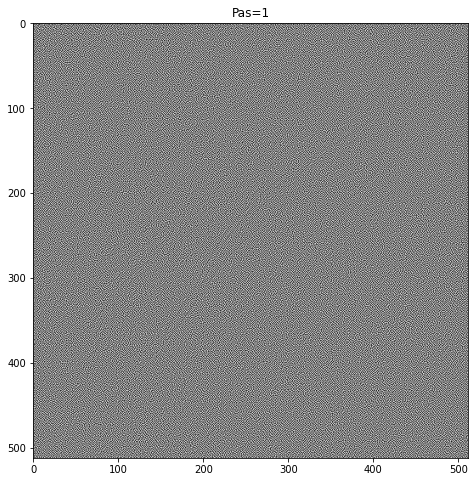

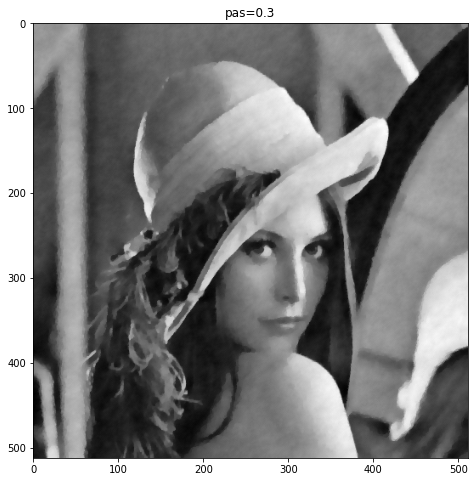

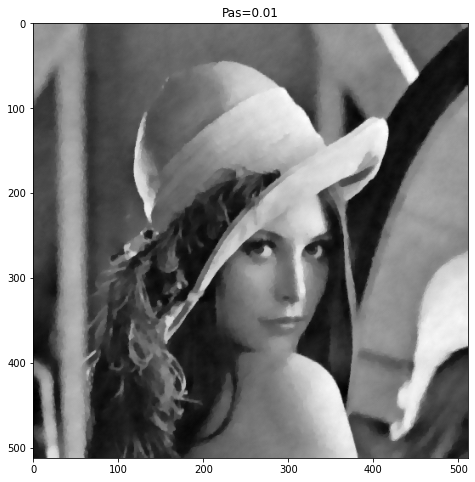

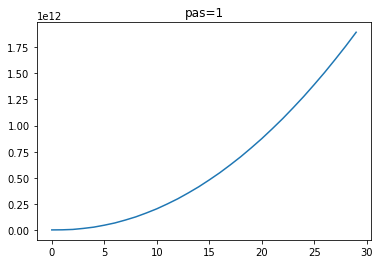

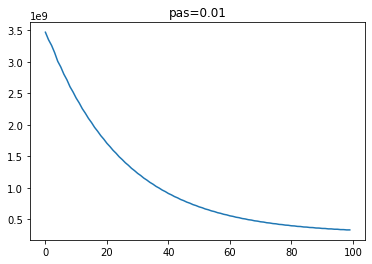

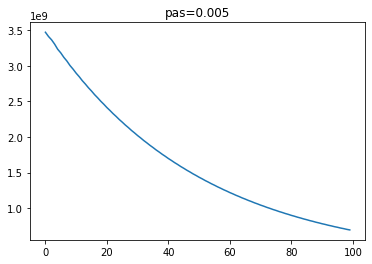

In [100]:
#%%
u1,en1=minimise_TV_gradient(imb, 40, 1, 30)

start = datetime.now()
u05,en05=minimise_TV_gradient(imb, 80, 0.01, 100)
end = datetime.now()

print(f'Exec time for 0.01 : {end-start}')

start = datetime.now()
u01,en01=minimise_TV_gradient(imb, 80, 0.005, 100)
end = datetime.now()
print(f'Exec time for 0.005 : {end-start}')

plt.figure(figsize=(8,8))
plt.imshow(u1, cmap='gray')
plt.title('Pas=1')

plt.figure(figsize=(8,8))
plt.imshow(u05, cmap='gray')
plt.title('pas=0.3')

plt.figure(figsize=(8,8))
plt.imshow(u01, cmap='gray')
plt.title('Pas=0.01')
#u05inf,en05inf=minimise_TV_gradient(imb, 10, 0.5, 200)

plt.figure()
plt.plot(en1)
plt.title('pas=1')

plt.figure()
plt.plot(en05)
plt.title('pas=0.01')

plt.figure()
plt.plot(en01)
plt.title('pas=0.005')


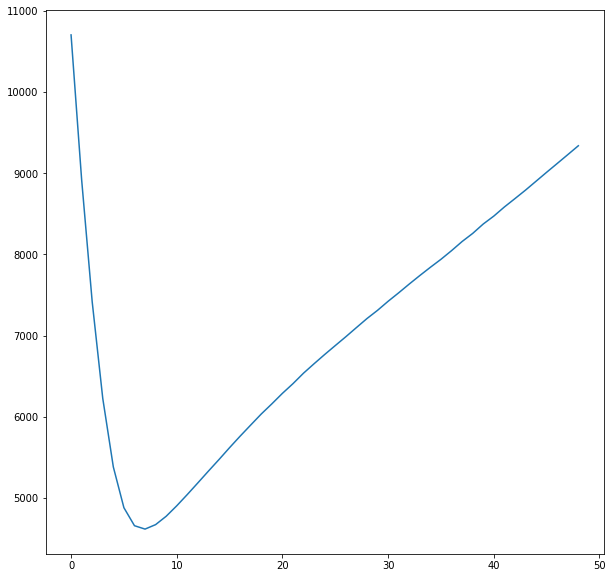

In [102]:
#Look for best lambda
err=[]
res=[]

for i in range(1, 50):
    u,en=minimise_TV_gradient(imb, 5*i, 0.05, 50)
    res.append(u)
    err.append(norm2(u-im))

plt.figure(figsize=(10, 10))
plt.plot(err)



In [105]:
errnp = np.array(err)
np.where(errnp == errnp.min())

(array([7], dtype=int64),)

In [90]:
print(en05[-1])
print(en01[-1])

263614561.0697136
649041050.6381545


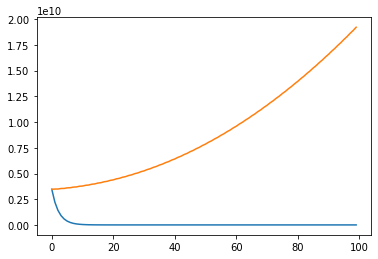

In [91]:
#%%
myim=imread('lena.tif')
imb=degrade_image(myim,25)
(u,energ)=minimise_TV_gradient(imb,1,0.1,100)   # pas = 0.1
(u,energ2)=minimise_TV_gradient(imb,1,1,100)       # pas = 1
plt.plot(energ)
plt.plot(energ2)


Execution time : 0:00:04.024272
Energy : 201085589.69150823


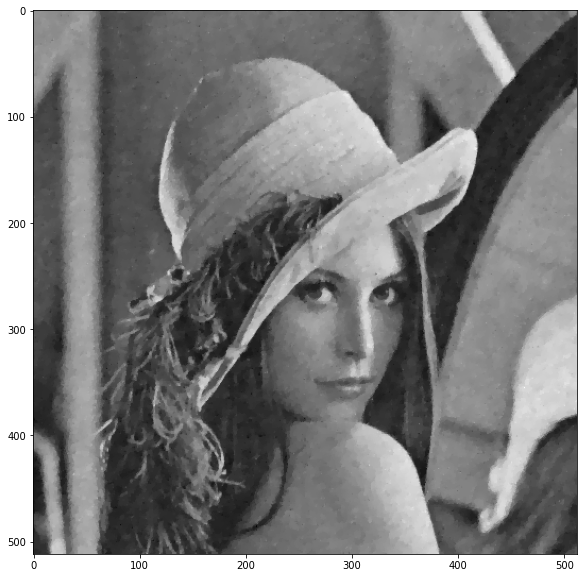

In [97]:
start_time=datetime.now()
res=vartotale_Chambolle(imb,40)
end_time=datetime.now()

print(f'Execution time : {end_time-start_time}')
energy = E2_nonperiodique(res, imb, 40)
print(f'Energy : {energy}')

plt.figure(figsize=(10, 10))
plt.imshow(res, cmap='gray')
plt.show()